# 3.7.6. Exercises


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt


class Data(d2l.DataModule):
  def __init__(self, num_train, num_val, num_inputs, batch_size):
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n, num_inputs)
    noise = torch.randn(n, 1) * 0.01
    w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
    self.y = torch.matmul(self.X, w) + b + noise

  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.X, self.y], train, i)

##### 1. Experiment with the value of $\lambda$ in the estimation problem in this section. Plot training and validation accuracy as a function of $\lambda$. What do you observe?

**在本节的估计问题中，尝试不同的 $\lambda$ 值。将训练和验证准确率绘制为 $\lambda$ 的函数。你观察到了什么？**


答：我们可以看到，通过适当地增加 $\lambda$ 的值，验证损失减少，表明过拟合问题得到了有效缓解。然而，当 $\lambda$ 太大时，训练和验证的损失都会非常高，表明模型无法有效拟合数据。


In [2]:
class WeightDecay(d2l.LinearRegression):
  def __init__(self, wd, lr, plot_flag=True):
    super().__init__(lr)
    self.save_hyperparameters()
    self.wd = wd

  def configure_optimizers(self):
    return torch.optim.SGD(
      [{"params": self.net.weight, "weight_decay": self.wd}, {"params": self.net.bias}], lr=self.lr
    )

  def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    if self.plot_flag:
      self.plot("loss", l, train=True)
    return l

  def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    if self.plot_flag:
      self.plot("loss", l, train=False)
    return l


@d2l.add_to_class(d2l.Trainer)  # @save
def return_train_loss(self):
  loss = 0
  for batch in self.train_dataloader:
    loss += self.model.training_step(self.prepare_batch(batch)).item()
  loss /= len(self.train_dataloader)
  return loss


@d2l.add_to_class(d2l.Trainer)  # @save
def return_val_loss(self):
  loss = 0
  for batch in self.val_dataloader:
    loss += self.model.validation_step(self.prepare_batch(batch)).item()
  loss /= len(self.val_dataloader)
  return loss

/Users/yangjing/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


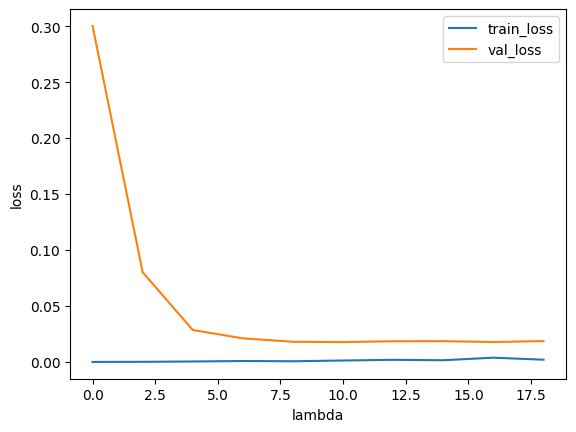

In [3]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
lambda_list = np.arange(0, 20, 2)
train_loss = []
val_loss = []

for lamb in lambda_list:
  trainer = d2l.Trainer(max_epochs=10)
  model = WeightDecay(wd=lamb, lr=0.01, plot_flag=False)
  trainer.fit(model, data)
  train_loss.append(trainer.return_train_loss())
  val_loss.append(trainer.return_val_loss())

plt.plot(lambda_list, train_loss, label="train_loss")
plt.plot(lambda_list, val_loss, label="val_loss")
plt.xlabel("lambda")
plt.ylabel("loss")
plt.legend()
plt.show()

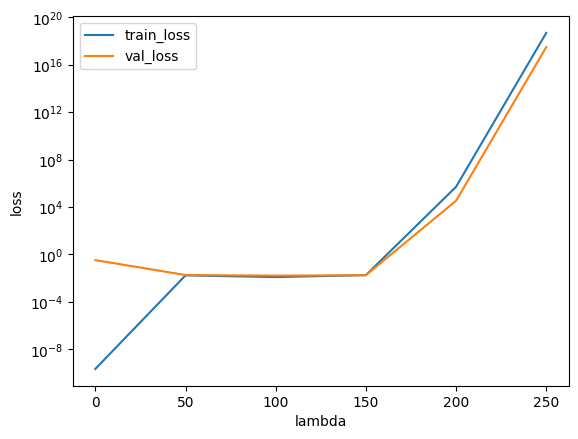

In [4]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
lambda_list = np.arange(0, 300, 50)
train_loss = []
val_loss = []

for lamb in lambda_list:
  trainer = d2l.Trainer(max_epochs=10)
  model = WeightDecay(wd=lamb, lr=0.01, plot_flag=False)
  trainer.fit(model, data)
  train_loss.append(trainer.return_train_loss())
  val_loss.append(trainer.return_val_loss())

plt.plot(lambda_list, train_loss, label="train_loss")
plt.plot(lambda_list, val_loss, label="val_loss")
plt.xlabel("lambda")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.show()

##### 2. Use a validation set to find the optimal value of $\lambda$. Is it really the optimal value? Does this matter?

**使用验证集找到 $\lambda$ 的最佳值。这真的是最佳值吗？这重要吗？**


答：虽然选择的 $\lambda$ 在特定的验证集上可能表现良好，但它可能不是未见测试数据的最佳值。因此，它并不是真正的最佳值。然而，如果 $\lambda$ 是最佳的，那也无所谓。我们可以相信，如果验证集能够代表整个数据集的分布和特征，那么 $\lambda$ 可以产生良好的结果。


##### 3. What would the update equations look like if instead of $|\mathbf{w}|^2$ we used $\sum_i |w_i|$ as our penalty of choice ($\ell_1$ regularization)?

**如果我们选择 $\sum_i |w_i|$ 作为惩罚项（$\ell_1$ 正则化） 替代 $|\mathbf{w}|^2$，更新方程将是什么样子？**


答：

$$
\begin{aligned}
\mathbf{w} & \leftarrow \mathbf{w} - \eta \lambda sign\left( \mathbf{w}\right) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$


##### 4. We know that $|\mathbf{w}|^2 = \mathbf{w}^\top \mathbf{w}$. Can you find a similar equation for matrices (see the Frobenius norm in Section 2.3.11)?

**我们知道 $|\mathbf{w}|^2 = \mathbf{w}^\top \mathbf{w}$。你能找到一个类似的矩阵方程吗（参见第 2.3.11 节中的弗罗贝尼乌斯范数）？**


答：

根据弗罗贝尼乌斯范数：

$$\|\mathbf{X}\|_\textrm{F} = \sqrt{\sum_{i=1}^m \sum_{j=1}^n x_{ij}^2}$$

然后我们可以得到一个类似的方程：

$$\|\mathbf{X}\|^2_\textrm{F} = tr(\mathbf{X}^T\mathbf{X})$$


##### 5. Review the relationship between training error and generalization error. In addition to weight decay, increased training, and the use of a model of suitable complexity, what other ways might help us deal with overfitting?

**回顾训练误差与泛化误差之间的关系。除了权重衰减、增加训练和使用适当复杂度的模型，还有哪些其他方法可以帮助我们应对过拟合？**


答：

1. 我们可以观察训练过程中训练误差和验证误差曲线的变化趋势。如果验证误差增加，这意味着过拟合，我们应该停止训练。
2. 我们可以使用 dropout 在每次训练迭代中随机停用一部分神经元，迫使网络学习稳健的表示。
3. 我们可以选择相关特征并减少无关特征，以帮助模型专注于数据中最重要的模式。


##### 6. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via $P(w \mid x) \propto P(x \mid w) P(w)$. How can you identify $P(w)$ with regularization?

**在贝叶斯统计中，我们使用先验和似然的乘积通过 $P(w \mid x) \propto P(x \mid w) P(w)$ 得到后验。你如何通过正则化识别 $P(w)$ ？**


答：先验分布 P(w) 可以作为一种正则化形式。对于 L2 正则化，先验分布 P(w) 被选择为均值为 0 和固定方差（尺度参数）的高斯分布。这鼓励参数值更接近于零，有效地惩罚较大的参数值。我们使用线性回归来证明这一点：

考虑一个线性回归模型：
$$\mathbf{y}=\mathbf{X}\mathbf{w}+\mathbf{\epsilon}$$

$\mathbf{\epsilon}$ 是误差向量，假设遵循高斯分布 $N(0, \sigma^2)$

似然函数为：
$$P(y|X,w,\sigma^2)=\frac1{(2\pi\sigma^2)^{n/2}}\exp\left(-\frac1{2\sigma^2}\|y-Xw\|^2\right)$$

假设 w 服从高斯分布 $N(0, \tau^2)$ 。w 的维度是 p。先验分布是：
$$P(w)=\frac1{(2\pi\tau^2)^{p/2}}\exp\left(-\frac1{2\tau^2}\|w\|^2\right)$$

MAP 估计的形式是：

$$
\begin{aligned}
\hat{\theta}_{\mathbf{MAP}}& =\arg\max_\theta P(\theta|y) \\
&=\arg\max_\theta\frac{P(y|\theta)P(\theta)}{P(y)} \\
&=\arg\max_\theta P(y|\theta)P(\theta) \\
&=\arg\max_\theta\log(P(y|\theta)P(\theta)) \\
&=\arg\max_\theta\log P(y|\theta)+\log P(\theta)
\end{aligned}
$$

结合上述方程：

$$
\begin{aligned}
\hat{w}_{\mathbf{MAP}} & = \arg \max_w \log P(y|X,w,\sigma^2) + \log P(w) \\
&= \arg\max_w -\frac1{2\sigma^2}\|y-Xw\|^2 -\frac1{2\tau^2}\|w\|^2 \\
&= \arg\min_w \|y-Xw\|^2 + \frac{\sigma^2}{\tau^2} \|w\|^2 \\
&= \arg\min_w \|y-Xw\|^2 + \lambda \|w\|^2
\end{aligned}
$$

L1 正则化引入了拉普拉斯分布作为参数的先验，这导致了稀疏性诱导效应。这可以将一些参数值驱动到精确为零，有效地执行特征选择。
